<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Phase_01_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import warnings
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

In [3]:
TRAIN_DATA_DIR = '/content/drive/MyDrive/dataset/train/images/'
TEST_DATA_DIR = '/content/drive/MyDrive/dataset/test/images/'

TRAIN_DATA_SIZE = 532
TEST_DATA_SIZE = 380

num_classes = 19

img_width = 224
img_height = 224

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

channels = 3

learning_rate = 1e-4

epochs = 10

In [4]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [5]:
CATEGORIES = list(label_map.values())

In [6]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, img_width, img_height):
    training_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return training_data

In [7]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES, img_width, img_height):
    test_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TEST_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                test_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return test_data

In [8]:
training_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, 
                                   img_width, img_height)

In [9]:
test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES, 
                              img_width, img_height)

In [10]:
random.shuffle(training_data)
random.shuffle(test_data)

In [11]:
val_data_size = int(len(training_data) * 0.3)
val_data = training_data[:val_data_size]
training_data = training_data[val_data_size:]

In [12]:
X = []
y = []
for features, classes in training_data:
    X.append(features)
    y.append(classes)

X = np.array(X).reshape(-1, img_width, img_height, channels)
y = np.array(y)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat = tf.keras.utils.to_categorical(y_val)

In [15]:
X_test = []
y_test = []
for features, classes in test_data:
    X_test.append(features)
    y_test.append(classes)

X_test = np.array(X_test).reshape(-1, img_width, img_height, channels)
y_test = np.array(y_test)

y_test_cat = tf.keras.utils.to_categorical(y_test)

In [16]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    brightness_range=[0.2, 1.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = ImageDataGenerator(rescale=1./255)

In [17]:
train_flow = train_generator.flow(
        X_train, 
        y_train_cat,
    )

In [18]:
val_flow = test_generator.flow(
        X_val,
        y_val_cat,
      )

In [19]:
test_flow = test_generator.flow(
        X_test,
        y_test_cat,
      )

In [152]:
base_model = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', 
                                             input_shape=(
                                                 img_width, 
                                                 img_height, 
                                                 channels
                                             )
                                            )

In [153]:
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, 230, 230, 3)  0          ['input_13[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_24[0][0]']      
                                )                                                       

In [154]:
last_layer = base_model.layers[-1].output
new_model = tf.keras.layers.GlobalAveragePooling2D()(last_layer)
new_model = tf.keras.layers.Dense(1024,activation='relu')(new_model)
new_model = tf.keras.layers.Dense(512,activation='relu')(new_model)
new_model = tf.keras.layers.Dropout(0.2)(new_model)
new_model = tf.keras.layers.Dense(19,activation='softmax')(new_model)

model = tf.keras.Model(inputs= base_model.input, outputs=new_model)

In [155]:
base_model.trainable = False

In [156]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [157]:
es = tf.keras.callbacks.EarlyStopping(patience=2)
epochs = 10
batch_size = 32

In [158]:
history = model.fit(        
        train_flow,
        batch_size = batch_size,
        epochs= epochs,
        callbacks= [es],
        validation_data= val_flow,
    )

Epoch 1/10
9/9 [==============================] - 72s 7s/step - loss: 3.0003 - accuracy: 0.0728 - val_loss: 3.0282 - val_accuracy: 0.0357
Epoch 2/10
9/9 [==============================] - 59s 7s/step - loss: 2.7476 - accuracy: 0.1571 - val_loss: 2.8648 - val_accuracy: 0.0714
Epoch 3/10
9/9 [==============================] - 58s 7s/step - loss: 2.5872 - accuracy: 0.2452 - val_loss: 2.7499 - val_accuracy: 0.1161
Epoch 4/10
9/9 [==============================] - 64s 8s/step - loss: 2.4443 - accuracy: 0.2835 - val_loss: 2.6375 - val_accuracy: 0.2143
Epoch 5/10
9/9 [==============================] - 62s 7s/step - loss: 2.2608 - accuracy: 0.4215 - val_loss: 2.4919 - val_accuracy: 0.2946
Epoch 6/10
9/9 [==============================] - 62s 7s/step - loss: 2.1099 - accuracy: 0.4598 - val_loss: 2.3724 - val_accuracy: 0.3214
Epoch 7/10
9/9 [==============================] - 63s 7s/step - loss: 1.9643 - accuracy: 0.5249 - val_loss: 2.2301 - val_accuracy: 0.3304
Epoch 8/10
9/9 [==================

In [159]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block31_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [160]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [161]:
history = model.fit(
        train_flow,
        epochs= epochs,
        batch_size = batch_size,
        callbacks= [es],
        validation_data= val_flow,
    )

Epoch 1/10
9/9 [==============================] - 76s 7s/step - loss: 1.7192 - accuracy: 0.5172 - val_loss: 2.0207 - val_accuracy: 0.3929
Epoch 2/10
9/9 [==============================] - 59s 7s/step - loss: 1.5610 - accuracy: 0.5594 - val_loss: 1.9159 - val_accuracy: 0.4018
Epoch 3/10
9/9 [==============================] - 59s 7s/step - loss: 1.4019 - accuracy: 0.6513 - val_loss: 1.7426 - val_accuracy: 0.4911
Epoch 4/10
9/9 [==============================] - 59s 7s/step - loss: 1.3535 - accuracy: 0.6513 - val_loss: 1.7291 - val_accuracy: 0.4732
Epoch 5/10
9/9 [==============================] - 63s 7s/step - loss: 1.2822 - accuracy: 0.6743 - val_loss: 1.7161 - val_accuracy: 0.4821
Epoch 6/10
9/9 [==============================] - 63s 7s/step - loss: 1.1590 - accuracy: 0.6705 - val_loss: 1.6496 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 58s 7s/step - loss: 1.1236 - accuracy: 0.6973 - val_loss: 1.6069 - val_accuracy: 0.5179
Epoch 8/10
9/9 [==================

In [162]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label = "training")
    plt.plot(epochs, val_acc, label = "validation")
    plt.legend(loc="upper left")
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label = "training")
    plt.plot(epochs, val_loss, label = "validation")
    plt.legend(loc="upper right")
    plt.title('Training and validation loss')

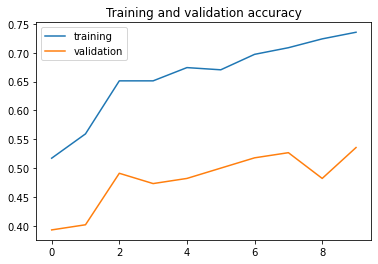

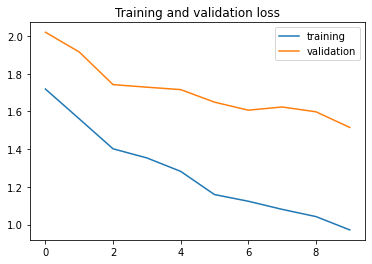

In [163]:
plot_history(history)

In [164]:
# model = load_model('image_classification_model.h5')

In [165]:
# predictions = model.predict(X_test)
# y_pred = np.argmax(predictions, axis=1)

In [166]:
# print('Confusion Matrix')
# print(confusion_matrix(y_test, y_pred))

# print()

# print('Classification Report')
# print(classification_report(y_test, 
#                             y_pred, 
#                             target_names=CATEGORIES))

In [167]:
# model.save('image_model.h5')

In [168]:
loss_and_metrics = model.evaluate(test_flow, verbose=2)

12/12 - 56s - loss: 1.4917 - accuracy: 0.5658 - 56s/epoch - 5s/step
